In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
from astropy.io import fits
import easydarkfigs
import pcmdpy as ppy
from tqdm import tqdm
import pandas as pd
from numpy.linalg import eig, inv
import seaborn as sns
%matplotlib inline

In [2]:
def get_XY(image):
    ny, nx = image.shape
    Y, X = np.mgrid[:ny, :nx]
    return X, Y

def get_RTheta(image, xc=0, yc=0):
    X, Y = get_XY(image)
    X = X - xc
    Y = Y - yc
    R = np.sqrt(X**2 + Y**2)
    Theta = np.arctan2(Y, X)
    return R, Theta

In [3]:
mags = {}
colors = {}
regions = {}

In [4]:
centers = {
    'NGC4993': (2827, 2659),
    'NGC3377': (3050, 2704),
    'M87': (2815, 2600),
    'M49': (2418, 2614),
}

In [5]:
gal = 'NGC4993'
red = 'F850LP'
blue = 'F475W'
f = ppy.instrument.default_ngc4993_filters()
with fits.open(f'../data/{gal}/reduced/{gal}_{red}_drc.fits') as h:
    mags[gal] = f[0].counts_to_mag(h['SCI'].data)
    regions[gal] = h['REGIONS'].data
with fits.open(f'../data/{gal}/reduced/{gal}_{blue}_drc.fits') as h:
    colors[gal] = f[1].counts_to_mag(h['SCI'].data) - mags[gal]

In [6]:
gal = 'NGC3377'
red = 'F850LP'
blue = 'F475W'
f = ppy.instrument.default_ngc3377_filters()
with fits.open(f'../data/{gal}/reduced/{gal}_{red}_drc.fits') as h:
    mags[gal] = f[0].counts_to_mag(h['SCI'].data)
    regions[gal] = h['REGIONS'].data
with fits.open(f'../data/{gal}/reduced/{gal}_{blue}_drc.fits') as h:
    colors[gal] = f[1].counts_to_mag(h['SCI'].data) - mags[gal]

In [7]:
gal = 'M49'
red = 'F850LP'
blue = 'F475W'
f = ppy.instrument.default_m49_filters()
with fits.open(f'../data/{gal}/reduced/{gal}_{red}_drc.fits') as h:
    mags[gal] = f[0].counts_to_mag(h['SCI'].data)
    regions[gal] = h['REGIONS'].data
with fits.open(f'../data/{gal}/reduced/{gal}_{blue}_drc.fits') as h:
    colors[gal] = f[1].counts_to_mag(h['SCI'].data) - mags[gal]

In [8]:
gal = 'M87'
red = 'F814W'
blue = 'F606W'
f = ppy.instrument.default_m87_filters()
with fits.open(f'../data/{gal}/reduced/{gal}_{red}_drc.fits') as h:
    mags[gal] = f[0].counts_to_mag(h['SCI'].data)
    regions[gal] = h['REGIONS'].data
with fits.open(f'../data/{gal}/reduced/{gal}_{blue}_drc.fits') as h:
    colors[gal] = f[1].counts_to_mag(h['SCI'].data) - mags[gal]

In [9]:
def plot_image(image, mask, ax=None):
    """
    Plot an image, with only a particular mask of a region shown
    """
    im = np.zeros_like(image)
    data = image[mask]
    im[mask] = data
    im[~mask] = np.nan
    if ax is None:
        fig, ax = plt.subplots()
    plt.subplot(ax)
    plt.imshow(im, norm=mpl.colors.Normalize(vmin=np.percentile(data, 1), vmax=np.percentile(data, 99)), cmap='viridis_r')
    ys, xs = np.where(mask)
    ax.set_xlim([xs.min(), xs.max()])
    ax.set_ylim([ys.min(), ys.max()])
    plt.colorbar()
    return ax

In [10]:
def correct_angle(theta):
    """
    Convert an angle theta (or array of angles) to [-pi, pi)
    """
    if isinstance(theta, float):
        if theta < -np.pi:
            return theta + 2*np.pi
        elif theta >= np.pi:
            return theta - 2*np.pi
        else:
            return theta
    else:
        theta[theta < -np.pi] += 2*np.pi
        theta[theta >= np.pi] -= 2*np.pi
    return theta

In [11]:
def is_between(thetas, lower, upper):
    """
    Evaluate if angles thetas are between lower and upper (including circularity)
    """
    lower, upper = correct_angle(np.array([lower, upper]))
    if lower <= upper:
        return (lower <= thetas) & (thetas <= upper)
    else:  # if upper loops around
        return (upper <= thetas) & (thetas <= lower)

In [12]:
def getEllipseParamsManual(mask, xc, yc, dtheta=0.05):
    """
    Given an image mask corresponding to a roughly-elliptical region, compute the elliptical
    parameters corresponding to the inner edge.
    
    Parameters
    ==========
    mask : 
    xc, yc : center position of the ellipse
    dtheta : allowed angular region to search for semi-major axis
    
    Returns
    =======
    xc, yc : central positions of the ellipse
    a : semi-major axis (scaled to unit 1)
    b : semi-minor axis (scaled to unit 1)
    r : scale radius of the ellipse (in pixels)
    phi : position angle
    """
    R, Theta = get_RTheta(mask, xc=xc, yc=yc)
    # Compute the radius to nearest inner edge (semi-minor axis)
    R = R[mask]
    Theta = Theta[mask]
    b = R.min()
    Theta_min = Theta[R.argmin()]
    # Look at points at +/- 90 degrees from inner-most edge
    t1, t2 = correct_angle(np.array([-dtheta, dtheta]) + Theta_min - np.pi/2)
    t3, t4 = correct_angle(np.array([-dtheta, dtheta]) + Theta_min + np.pi/2)
    far_mask_1 = is_between(Theta, t1, t2)
    far_mask_2 = is_between(Theta, t3, t4)
    # Compute the radius to farthest inner edge (semi-major axis)
    a_1 = R[far_mask_1].min() if far_mask_1.sum() > 0 else None
    a_2 = R[far_mask_2].min() if far_mask_2.sum() > 0 else None
    if (a_1 is not None) and (a_2 is not None):
        a = 0.5 * (a_1 + a_2)
    elif (a_1 is not None):
        a = a_1
    elif (a_2 is not None):
        a = a_2
    else:
        a = b
    Theta_max = correct_angle(Theta_min + np.pi/2.)
    r = np.sqrt(a**2 + b**2)
    phi = Theta_max
    return xc, yc, a/r, b/r, r, phi

In [13]:
class EllipticalFit:
    
    def __init__(self, mask, xc, yc, dtheta=0.05):
        self.xc = xc
        self.yc = yc
        _, _, self.a, self.b, self.r, self.phi = getEllipseParamsManual(mask, xc=xc, yc=yc, dtheta=dtheta)
        self.mask = mask
        
    def plot_ellipse(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots()
        R = np.arange(0, 2*np.pi, 0.01)
        t1, t2 = self.a*self.r, self.b*self.r
        xx = self.xc + t1*np.cos(R)*np.cos(self.phi) - t2*np.sin(R)*np.sin(self.phi)
        yy = self.yc + t1*np.cos(R)*np.sin(self.phi) + t2*np.sin(R)*np.cos(self.phi)
        ax.plot(xx, yy, 'r:')
        return ax
    
    def transform(self, mask=None):
        if mask is None:
            mask = self.mask
        Xs, Ys = get_XY(mask)
        X, Y = (Xs[mask] - self.xc), (Ys[mask] - self.yc)
        X_rot = X*np.cos(-self.phi) - Y*np.sin(-self.phi)
        Y_rot = Y*np.cos(-self.phi) + X*np.sin(-self.phi)
        r = np.sqrt((X_rot / self.a)**2 + (Y_rot / self.b)**2)
        theta = np.arctan2(Y_rot/self.b, X_rot/self.a)
        return r, theta
    
    def plot_radii(self, mask=None, ax=None):
        if mask is None:
            mask = self.mask
        rs, thetas = self.transform(mask)
        im = np.zeros_like(mask, dtype=float)
        im[mask] = rs
        im[~mask] = np.nan
        if ax is None:
            fig, ax = plt.subplots()
        plt.subplot(ax)
        plt.imshow(im, norm=mpl.colors.Normalize(vmin=rs.min(), vmax=rs.max()))
        ys, xs = np.where(mask)
        ax.set_xlim([xs.min(), xs.max()])
        ax.set_ylim([ys.min(), ys.max()])
        plt.colorbar()
        return ax
    
    def plot_radial_gradient(self, values, mask=None, ax=None, n_bins=10, **kwargs):
        if mask is None:
            mask = self.mask
        R, Theta = self.transform(mask)
        y = values[mask]
        kw = {'x_estimator': np.median,
              'x_bins': n_bins,
             'x_ci': 'sd'}
        kw.update(kwargs)
        if ax is None:
            fig, ax = plt.subplots()
        sns.regplot(x=R, y=y, ax=ax, **kw)
        return ax
    
    def plot_angular_gradient(self, values, mask=None, ax=None, n_bins=10, **kwargs):
        if mask is None:
            mask = self.mask
        R, Theta = self.transform(mask)
        y = values[mask]
        kw = {'x_estimator': np.median,
              'x_bins': n_bins,
             'x_ci': 'sd'}
        kw.update(kwargs)
        if ax is None:
            fig, ax = plt.subplots()
        sns.regplot(x=Theta, y=y, ax=ax, **kw)
        return ax
    
    def delta_val(self, values, mask=None, n_bins=10, func=np.median, 
                 subtract=True):
        if mask is None:
            mask = self.mask
        R, Theta = self.transform(mask)
        y = values[mask]
        bins = np.linspace(R.min()-0.01, R.max()+0.01, n_bins+1)
        ids = np.digitize(R, bins)
        inner = (ids == 1)
        outer = (ids == n_bins)
        if subtract:
            return func(y[outer]) - func(y[inner])
        else:
            return func(y[outer]) / func(y[inner])

In [14]:
ellips = {}
delta_mags = {}

In [ ]:
for k, r in regions.items():
    ellips[k] = {}
    xc, yc = centers[k]
    delta_mags[k] = []
    for i in tqdm(range(r.max() // 4), desc=k):
        mask = (r >= 4*i + 1)&(r < 4*(i+1) + 1)
        ellips[k][i] = EllipticalFit(mask, xc=xc, yc=yc)
        delta_mags[k].append(ellips[k][i].delta_val(mags[k]))

M87: 100%|██████████| 90/90 [04:29<00:00,  3.00s/it]


In [ ]:
delta_red = {}
delta_blue = {}
for k, e in ellips.items():
    delta_red[k] = {}
    delta_blue[k] = {}
    for i in tqdm(range(1, regions[k].max()), desc=k):
        if (i // 4 - 1) not in e:
            continue
        if (regions[k] == i).sum() >= 10:
            delta_red[k][i] = e[i//4 - 1].delta_val(mags[k], mask=(regions[k] == i))
            delta_blue[k][i] = e[i//4 - 1].delta_val(colors[k]+mags[k], mask=(regions[k] == i))

M49:  31%|███       | 104/339 [03:03<06:55,  1.77s/it]

In [16]:
radii = {}
for k, e in ellips.items():
    radii[k] = {}
    for i in tqdm(range(1, regions[k].max()), desc=k):
        if (i // 4 - 1) not in e:
            continue
        if (regions[k] == i).sum() >= 10:
            radii[k][i] = np.mean(e[i//4 - 1].transform(mask=(regions[k] == i))[0] * e[i//4 - 1].a)

M87: 100%|██████████| 359/359 [04:32<00:00,  1.32it/s]


In [21]:
regions['NGC4993'].max()

316

In [17]:
df_radii = pd.DataFrame.from_dict(radii)
df_radii.head()

,NGC4993,NGC3377,M49,M87
4,866.524033,1854.573996,1808.240871,1859.819654
5,845.036532,1797.351230,1805.732398,1845.136882
6,872.400209,1826.770922,1772.004918,1854.262074
7,853.807569,1811.777403,1813.220218,1867.181817
8,839.492139,1839.368557,1802.422899,1852.255262


In [23]:
df_radii.to_csv('results/regions_radii.csv')

In [ ]:
df_radii["M87"][]

In [ ]:
df_red = pd.DataFrame.from_dict(delta_red)

In [ ]:
df_blue = pd.DataFrame.from_dict(delta_blue)

In [ ]:
df_red.head(10)

In [ ]:
df_red.to_csv('results/regions_delta_red.csv')

In [ ]:
df_blue.to_csv('results/regions_delta_blue.csv')

(0.011520386, <matplotlib.axes._subplots.AxesSubplot at 0x1a1a41080>)

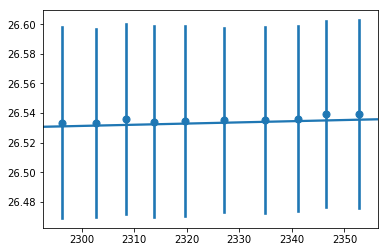

In [93]:
delta_red['M87'][44], ellips['M87'][44//4 - 1].plot_radial_gradient(mags['M87'])

(0.021905899, <matplotlib.axes._subplots.AxesSubplot at 0x19f9056d8>)

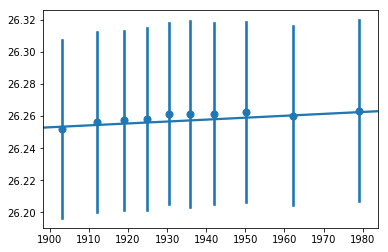

In [94]:
delta_red['M87'][104], ellips['M87'][104//4 - 1].plot_radial_gradient(mags['M87'])

(0.07200432, <matplotlib.axes._subplots.AxesSubplot at 0x1a19cc828>)

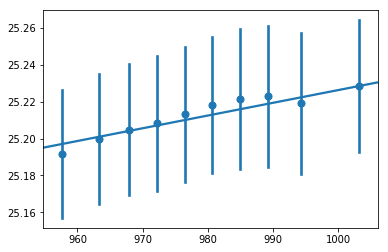

In [95]:
delta_red['M87'][204], ellips['M87'][204//4 - 1].plot_radial_gradient(mags['M87'])

In [57]:
ellips['M87'][44].delta_val(mags['M87'])

0.05626297

In [ ]:
delta_red['M87'][44], ellips['M87'][44].plot_radial_gradient(mags['M87'])

In [ ]:
delta_red['M87'][44], ellips['M87'][44].plot_radial_gradient(mags['M87'])

In [ ]:
delta_red['M87'][44], ellips['M87'][44].plot_radial_gradient(mags['M87'])

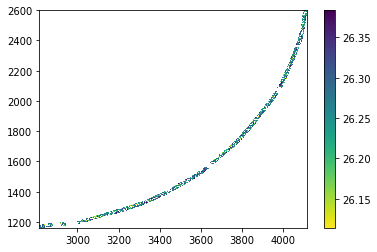

In [38]:
plot_image(mags['M87'], (regions['M87']==104))

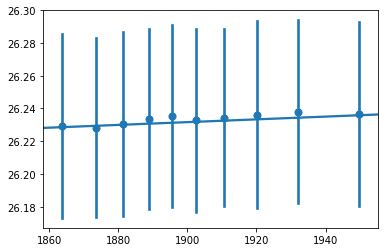

In [40]:
ellips['M87'][104//4].plot_radial_gradient(mags['M87'])

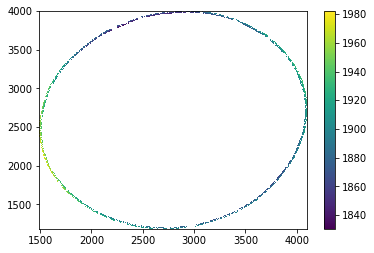

In [41]:
ellips['M87'][104//4].plot_radii()

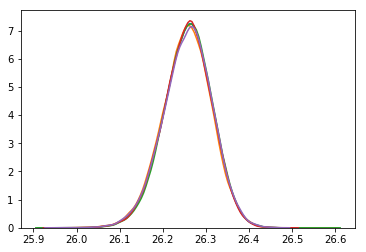

In [83]:
sns.kdeplot(mags['M87'][ellips['M87'][104//4 - 1].mask])
sns.kdeplot(mags['M87'][regions['M87']==101])
sns.kdeplot(mags['M87'][regions['M87']==102])
sns.kdeplot(mags['M87'][regions['M87']==103])
sns.kdeplot(mags['M87'][regions['M87']==104])

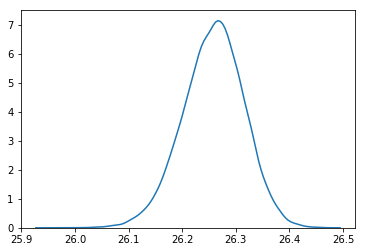

In [44]:
delta_red['M87'][101], delta_blue['M87'][101]

(0.01861763, -0.021453857)

In [45]:
delta_red['M87'][102], delta_blue['M87'][102]

(0.019996643, -0.0059165955)

In [46]:
delta_red['M87'][103], delta_blue['M87'][103]

(0.02239418, -0.028949738)

In [47]:
delta_red['M87'][104], delta_blue['M87'][104]

(0.025344849, -0.032003403)

In [16]:
# k, r = 'NGC4993', regions['NGC4993']
# ellips[k] = {}
# xc, yc = centers[k]
# delta_mags[k] = []
# for i in tqdm(range(r.max() // 4), desc=k):
#     mask = (r >= 4*i + 1)&(r < 4*(i+1) + 1)
#     ellips[k][i] = EllipticalFit(mask, xc=xc, yc=yc)
#     delta_mags[k].append(ellips[k][i].delta_val(mags[k]))

In [17]:
xs = {k: list(ells.keys()) for k, ells in ellips.items()}

In [48]:
ellips['M87'][10].delta_val(colors['M87']+mags['M87'])

0.023935318

In [19]:
ellips['M87'][10].delta_val(mags['M87'])

0.004590988

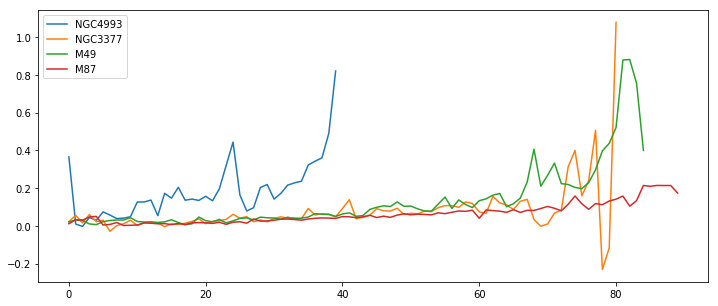

In [27]:
fig, ax = plt.subplots(figsize=(12, 5))
for k in ellips.keys():
    ax.plot(xs[k], delta_mags[k], label=k, marker='', ls='-')
ax.legend(loc=0)

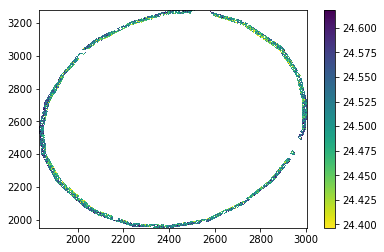

In [28]:
plot_image(mags['M49'], mask=ellips['M49'][45].mask)

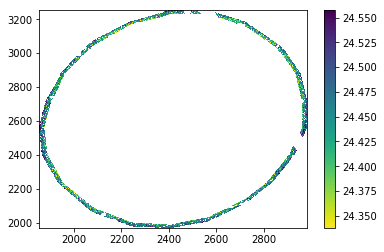

In [29]:
plot_image(mags['M49'], mask=ellips['M49'][46].mask)

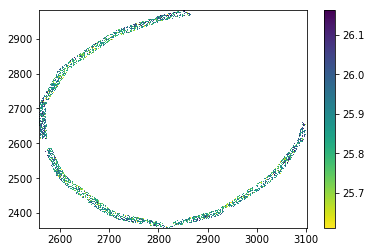

In [26]:
plot_image(mags['NGC4993'], mask=ellips['NGC4993'][10].mask)

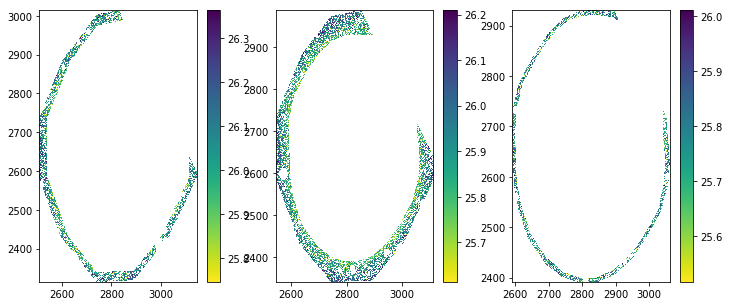

In [35]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 5))
plot_image(mags, mask=fit_66.mask, ax=axes[0])
plot_image(mags, mask=fit_70.mask, ax=axes[1])
plot_image(mags, mask=fit_74.mask, ax=axes[2])

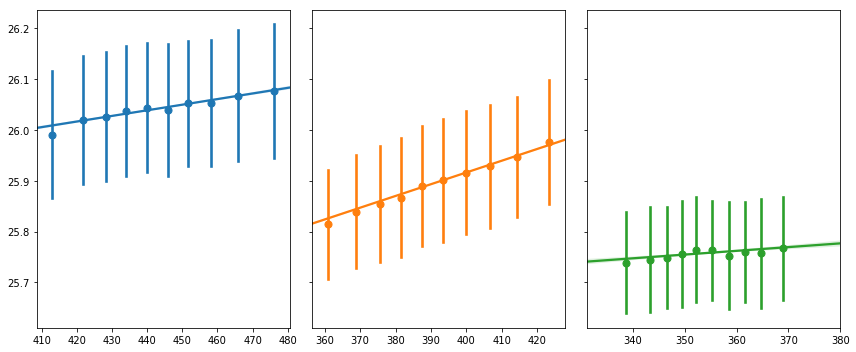

In [38]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 5), sharey=True)
fit_66.plot_radial_gradient(mags, ax=axes[0])
fit_70.plot_radial_gradient(mags, ax=axes[1])
fit_74.plot_radial_gradient(mags, ax=axes[2])
axes[2].set_xlim(xmax=380)
plt.tight_layout()

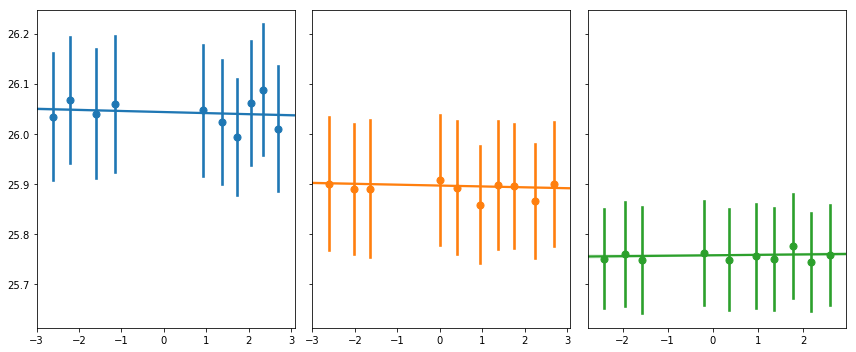

In [40]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 5), sharey=True)
fit_66.plot_angular_gradient(mags, ax=axes[0])
fit_70.plot_angular_gradient(mags, ax=axes[1])
fit_74.plot_angular_gradient(mags, ax=axes[2])
# axes[2].set_xlim(xmax=380)
plt.tight_layout()

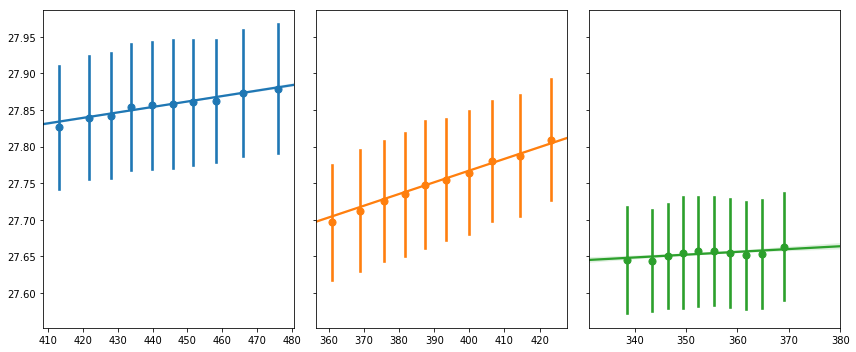

In [39]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 5), sharey=True)
fit_66.plot_radial_gradient(colors+mags, ax=axes[0])
fit_70.plot_radial_gradient(colors+mags, ax=axes[1])
fit_74.plot_radial_gradient(colors+mags, ax=axes[2])
axes[2].set_xlim(xmax=380)
plt.tight_layout()